# Expanded Baseline Model

In order to more thoroughly test the baseline model, a single node decision tree, I will train it using a simple heuristic in order to find an ideal discrimination threshold and then test the threshold on a test set.

## Function Definitions and Imports

In [2]:
import json

# Default threshold function
def get_f1(thresh, term_freqs, solution):
    # Predict
    predictions = {}
    for doc in term_freqs.keys():
        predictions[doc] = [key for key, val in term_freqs[doc].items() if val > thresh]
        
    # Get evaluation metrics
    true_pos = 0
    false_pos = 0
    false_neg = 0
    
    for pmid in predictions:
        true_pos += len([pred for pred in predictions[pmid] if pred in solution[pmid]])
        false_pos += len([pred for pred in predictions[pmid] if pred not in solution[pmid]])
        false_neg += len([sol for sol in solution[pmid] if sol not in predictions[pmid]])

    if true_pos == 0:
        precision = 0
        recall = 0
        f1 = 0
    else:
        precision = true_pos / (true_pos + false_pos)
        recall = true_pos / (true_pos + false_neg)
        f1 = (2 * precision * recall) / (precision + recall)
    
    return f1

def train(term_freqs, solution):
    curr_thresh = 0.0
    step_val = 0.001
    f1s = []
    
    f1s.append(get_f1(curr_thresh, term_freqs, solution))
    f1s.append(get_f1(curr_thresh + step_val, term_freqs, solution))
    
    curr_thresh += step_val
    next_thresh_f1 = get_f1(curr_thresh + step_val, term_freqs, solution)
    
    while not (next_thresh_f1 < f1s[-1] and next_thresh_f1 < f1s[-2] and f1s[-1] < f1s[-2]):
        curr_thresh += step_val
        f1s.append(get_f1(curr_thresh, term_freqs, solution))
        next_thresh_f1 = get_f1(curr_thresh + step_val, term_freqs, solution)
    
    return curr_thresh - step_val

def predict(test_freqs, thresh, solution):

    # Test it out
    predictions = {}
            
    # Predict
    for doc in test_freqs.keys():
        predictions[doc] = [key for key, val in test_freqs[doc].items() if val > thresh]
    # Get evaluation metrics
    true_pos = 0
    false_pos = 0
    false_neg = 0
    
    for pmid in predictions:
        true_pos += len([pred for pred in predictions[pmid] if pred in solution[pmid]])
        false_pos += len([pred for pred in predictions[pmid] if pred not in solution[pmid]])
        false_neg += len([sol for sol in solution[pmid] if sol not in predictions[pmid]])

    if true_pos == 0:
        precision = 0
        recall = 0
        f1 = 0
    else:
        precision = true_pos / (true_pos + false_pos)
        recall = true_pos / (true_pos + false_neg)
        f1 = (2 * precision * recall) / (precision + recall)

    return predictions, f1

In [3]:
# Load in term frequencies and partition
with open("./data/term_freqs_rev_3_all_terms.json", "r") as handle:
    temp = json.load(handle)

docs_list = list(temp.keys())
partition = int(len(docs_list) * .8)

train_docs = docs_list[0:partition]
test_docs = docs_list[partition:]

# Load in solution values
solution = {}
docs_list = set(docs_list)
with open("./data/pm_doc_term_counts.csv", "r") as handle:
    for line in handle:
        line = line.strip("\n").split(",")
        if line[0] in docs_list:
            # Only use samples indexed with MeSH terms
            terms = [term for term in line[1:] if term]
            if terms:
                solution[line[0]] = terms

# Build training/test data, ensure good solution data is available
# Solution data is not always available because documents may not be
# indexed - even though obviously some of their references have been indexed
train_freqs = {}
for doc in train_docs:
    if doc in solution.keys():
        train_freqs[doc] = temp[doc]

test_freqs = {}
for doc in test_docs:
    if doc in solution.keys():
        test_freqs[doc] = temp[doc]  

thresh = train(train_freqs, solution)

preds, f1 = predict(test_freqs, thresh, solution)

print(f"Learned discrimination threshold: {thresh}")
print(f"Micro-averaged F1 from test set: {f1}")

Learned discrimination threshold: 0.016000000000000007
Micro-averaged F1 from test set: 0.4653554867124998


I'm also curious about what some of these results look like, so I'm going to modify the predict function in order to record the F1s for each sample, and separately the F1s for each sample with more than 20 MeSH terms applied to all of its citations. I'm also going to load in a dictionary to convert MeSH UIDs to natural language.

In [43]:
def predict(test_freqs, thresh, solution):
    predictions = {}
    f1s = {}
    f1s_all = {}
    
    # Predict
    for doc in test_freqs.keys():
        predictions[doc] = [key for key, val in test_freqs[doc].items() if val > thresh]

    for pmid in predictions:
        true_pos = len([pred for pred in predictions[pmid] if pred in solution[pmid]])
        false_pos = len([pred for pred in predictions[pmid] if pred not in solution[pmid]])
        false_neg = len([sol for sol in solution[pmid] if sol not in predictions[pmid]])

        if true_pos == 0:
            precision = 0
            recall = 0
            f1 = 0
        else:
            precision = true_pos / (true_pos + false_pos)
            recall = true_pos / (true_pos + false_neg)
            f1 = (2 * precision * recall) / (precision + recall)
        if len(predictions[pmid]) > 20:
            f1s[pmid] = f1
            
        f1s_all[pmid] = f1
        
    return f1s, f1s_all, predictions

term_names = {}
with open("./data/mesh_data.tab", "r") as handle:
    for line in handle:
        line = line.strip("\n").split("\t")
        term_names[line[0]] = line[1]
        
f1s, f1s_all, predictions = predict(test_freqs, thresh, solution)

In [44]:
max_f1 = max(f1s.values())
min_f1 = min(f1s.values())

max_pmids = [key for key, value in f1s.items() if value == max_f1]
min_pmids = [key for key, value in f1s.items() if value == min_f1]

print(f"Maximum F1: {max_f1}, found for {len(max_pmids)} PMIDs")
print(f"Minimum F1: {min_f1}, found for {len(min_pmids)} PMIDs")

Maximum F1: 0.9500000000000001, found for PMIDs: 1
Minimum F1: 0, found for PMIDs: 8


Let's look at the predictions and solutions for the best scoring sample.

In [45]:
max_preds = ", ".join([term_names[pred] for pred in predictions[max_pmids[0]]])
max_sol = ", ".join([term_names[sol] for sol in solution[max_pmids[0]]])
print(f"Predicted terms ({len(predictions[max_pmids[0]])}) for PMID {max_pmids[0]}: \n{max_preds}")
print(f"\nActual terms ({len(solution[max_pmids[0]])}) applied to PMID {max_pmids[0]}: \n{max_sol}")
print(f"\nNumber of MeSH terms applied to all of {max_pmids[0]}'s references: {len(test_freqs[max_pmids[0]].keys())}")

Predicted terms (21) for PMID 23314745: 
Adolescent, Antiviral Agents, Child, Child, Preschool, Drug Therapy, Combination, Humans, Interferon alpha-2, Interferon-alpha, Polyethylene Glycols, Recombinant Proteins, Ribavirin, Adult, Female, Treatment Outcome, Genotype, Hepacivirus, Hepatitis C, Chronic, Male, Viral Load, Interleukins, Polymorphism, Single Nucleotide

Actual terms (19) applied to PMID 23314745: 
Adolescent, Antiviral Agents, Child, Child, Preschool, Drug Therapy, Combination, Female, Genotype, Hepacivirus, Hepatitis C, Chronic, Humans, Interferon-alpha, Interleukins, Male, Polyethylene Glycols, Polymorphism, Single Nucleotide, Recombinant Proteins, Ribavirin, Treatment Outcome, Viral Load

Number of MeSH terms applied to all of 23314745's references: 98


This is pretty good. 23314745 had 98 terms applied to all and 21 were selected for prediction based on their relative frequency being greater than the discrimination threshold. However, samples like this are bound to occur when evaluating this much data.

Let's also take a look at a couple of the word predictions.

In [46]:
min_preds = ", ".join([term_names[pred] for pred in predictions[min_pmids[0]]])
min_sol = ", ".join([term_names[sol] for sol in solution[min_pmids[0]]])
print(f"Predicted terms for PMID {min_pmids[0]}: \n{min_preds}")
print(f"\nActual terms applied to PMID {min_pmids[0]}: \n{min_sol}")
print(f"\nNumber of MeSH terms applied to all of {min_pmids[0]}'s references: {len(test_freqs[min_pmids[0]].keys())}")

Predicted terms for PMID 21932250: 
Base Sequence, DNA Primers, Escherichia coli, Fermentation, Gene Deletion, Genetic Engineering, Genome, Bacterial, Molecular Sequence Data, Plasmids, Succinic Acid, Templates, Genetic, Anaerobiosis, Biosynthetic Pathways, Butylene Glycols, Glucose, Organisms, Genetically Modified, Alcohol Dehydrogenase, Aldehyde Reductase, Butanols, Cloning, Molecular, Escherichia coli Proteins, Fungal Proteins, Recombinant Proteins

Actual terms applied to PMID 21932250: 
Biofuels, Biomass, Biotechnology, Industrial Microbiology, Metabolic Engineering, Synthetic Biology

Number of MeSH terms applied to all of 21932250's references: 23


[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'F1 Score')]

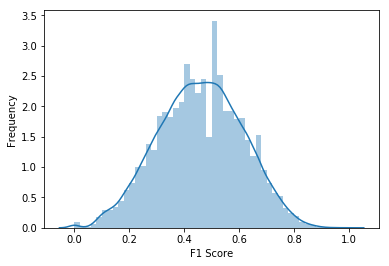

In [47]:
import seaborn as sns
import numpy as np

f1_vals = np.array(list(f1s_all.values()))
ax = sns.distplot(f1_vals)
ax.set(xlabel="F1 Score", ylabel="Frequency")

The distribution of F1 scores for samples in the test set. 